# Introduction

One of the key features of PorePy is the forward-mode automatic (or algorithmic) differentiation, or AD.
The AD is used to linearize a system of partial differential equations.

This tutorial introduces the basic usage of the AD and shows how it is incorporated into the PorePy models.

The time stepping algorithm at the core of PorePy involves numerically solving a discretized system of PDEs $F$ with respect to the vector of variables $x$. 
Most numerical solution algorithms rely on computing the Jacobian matrix of this system: $J:=\dfrac{\partial F}{\partial x}$. 
However, programming a formula to compute the Jacobian matrix can be difficult, as it requires analytic differentiation of the equation $F$.

Fortunately, the PorePy model developers do not need to perform this task, as the AD framework handles it for them.

# AD basics

The core of the AD framework is the `AdArray` class. It contains 2 attributes:
- `val` - the value of the variable it represents.
- `jac` - the Jacobian matrix of the variable it represents.

Let's create an independent variable - the vector `x = [1, 2, 3]`.
As the variable is independent, its Jacobian is the identity matrix:
$\dfrac{\partial x}{\partial x} = I$.

In [1]:
import numpy as np
import scipy.sparse as sps

from porepy.numerics.ad.forward_mode import AdArray

val = np.array([1, 2, 3])
jac = sps.eye(m=val.size)

x = AdArray(val=val, jac=jac)

print("Values:\n", x.val)
print("Jacobian:\n", x.jac.toarray())

Values:
 [1. 2. 3.]
Jacobian:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


Now we can use arithmetic operators to build any expression with $x$. For example:
$y(x) = 6 x^3 + 3 x - 6$

In [2]:
y = 6 * x**3 + 3 * x - 6

The values of the Jacobian $\dfrac{\partial y}{\partial x}$ are available automatically, and they are computed with respect to $x = [1, 2, 3]$.

In [3]:
print(y.jac.toarray())

[[ 21.   0.   0.]
 [  0.  75.   0.]
 [  0.   0. 165.]]


In addition to defining functions ourselves, we can access a collection of pre-defined standard functions. 
This collection contains functions such as `sin`, `cos`, `exp` and so on. 
We refer to the source code for seeing which functions are available, and continue with a simple example of how to access such a function:

In [4]:
import porepy.numerics.ad.functions as af

y = af.sin(x)
print(y.jac.toarray())

[[ 0.54030231  0.          0.        ]
 [ 0.         -0.41614684  0.        ]
 [ 0.          0.         -0.9899925 ]]


The AD framework supports NumPy arrays and SciPy sparse matrices. 
There are some limitations, but as this will not be covered in this tutorial, the user should check the documentation of the `AdArray` code to become aware of them.

Now we are ready to see how the AD is utilized in the PorePy models.

# AD in the models

We will now consider an example of `SinglePhaseFlow` model, which should be familiar from the [earlier tutorial](./single_phase_flow.ipynb) covering single physics.
This time we will not define the geometry manually, but instead use one of the pre-defined geometries provided by a mixin class.

In [5]:
import inspect
import porepy as pp
from porepy.applications.md_grids.model_geometries import (
    SquareDomainOrthogonalFractures,
)
from porepy.models.fluid_mass_balance import SinglePhaseFlow


class SinglePhaseFlowWithGeometry(SquareDomainOrthogonalFractures, SinglePhaseFlow):
    def meshing_arguments(self) -> dict:
        return {"cell_size": 0.25 / self.units.m}

Among many other things, PorePy model classes include methods for defining:
- the independent variables of the simulation
- the system of PDEs describing the physical laws of the simulation

All of these are called when the model is initialized in the `prepare_simulation` method.

<b>Note:</b>  When running the simulation, you should not call `prepare_simulation` directly. 
It is called inside `pp.run_time_dependent_model` or `pp.run_stationary_model`. 
Here, we run it for illustration purposes only, as we do not plan to run the simulation.

The grid:


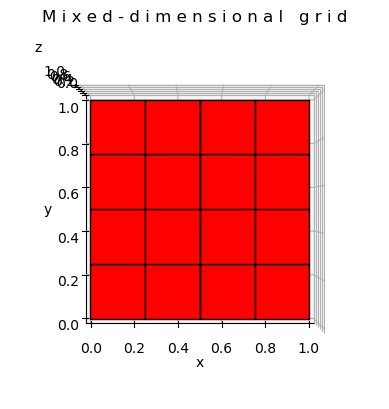

One fracture inside:


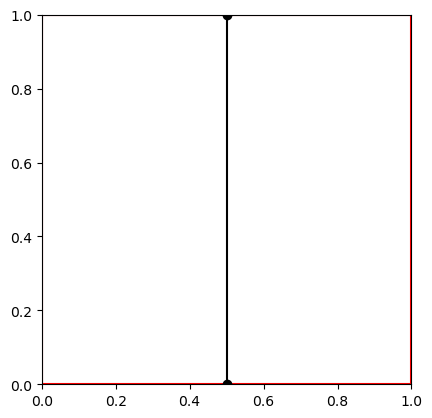

In [6]:
model = SinglePhaseFlowWithGeometry()
model.prepare_simulation()

print("The grid:")
pp.plot_grid(model.mdg)
print("One fracture inside:")
model.fracture_network.plot()

So, what happenes inside `model.prepare_simulation`?

In [7]:
print(inspect.getsource(model.prepare_simulation))

    def prepare_simulation(self) -> None:
        """Run at the start of simulation. Used for initialization etc."""
        # Set the geometry of the problem. This is a method that must be implemented
        # in a ModelGeometry class.
        self.set_geometry()

        # Exporter initialization must be done after grid creation,
        # but prior to data initialization.
        self.initialize_data_saving()

        # Set variables, constitutive relations, discretizations and equations.
        # Order of operations is important here.
        self.set_equation_system_manager()
        self.set_materials()
        self.create_variables()
        self.initial_condition()
        self.reset_state_from_file()
        self.set_equations()

        self.set_discretization_parameters()
        self.discretize()
        self._initialize_linear_solver()
        self.set_nonlinear_discretizations()

        # Export initial condition
        self.save_data_time_step()



The `prepare_simulation` method runs a sequence of initialization steps, all of which are important. 
However, we will focus on two steps for now:

- Initializing the independent variables of the simulation in the `create_variables` method. In our case, these are pressure $P$ and interface flux.
- Initializing the equations of the model in the `set_equations` method. In our case, these are the mass balance equation and the interface equations.

The bookkeeping of variables and equations is done with the `equation_system` attribute of the model:

In [8]:
model.equation_system

EquationSystem for mixed-dimensional grid with 2 subdomains and 1 interfaces.
Variables present on at least one grid or interface:
	pressure, interface_darcy_flux
In total 3 equations, with names: 
	mass_balance_equation, interface_darcy_flux_equation, well_flux_equation

## Variables creation
The variables are created in the method `create_variables`. Inside this method, we register all the model variables in the `equation_system`:

In [9]:
print(inspect.getsource(model.create_variables))

    def create_variables(self) -> None:
        """Assign primary variables to subdomains and interfaces of the
        mixed-dimensional grid.

        """
        self.equation_system.create_variables(
            self.pressure_variable,
            subdomains=self.mdg.subdomains(),
            tags={"si_units": "Pa"},
        )
        # Note that `interface_darcy_flux_variable` is not multiplied by rho * mu^-1.
        # However, after multiplication, whe know that the resulting flux should be a
        # mass flux with units  `kg * s^-1`. The units of `interface_darcy_flux` can
        # then be inferred by solving the below equation for `int_flux_units`:
        # kg * s^-1 = [kg * (m^nd)^-1] * [Pa * s]^-1 * intf_flux_units
        self.equation_system.create_variables(
            self.interface_darcy_flux_variable,
            interfaces=self.mdg.interfaces(codim=1),
            tags={"si_units": f"m^{self.nd} * Pa"},
        )
        self.equation_system.create_variables(
   

Within PorePy, it is a common practice to store the variable names as an attribute of the model.
The name of, for instance, the pressure variable can be obtained like this:

In [10]:
model.pressure_variable

'pressure'

Accessing the variable itself can be done by using the variable name like this:

In [11]:
p = model.equation_system.md_variable(model.pressure_variable)
p

Mixed-dimensional variable with name pressure, id 28
Composed of 2 variables
Total size: 20

Unlike the `AdArray`, a variable is an abstract AD object that does not store any values.
It is used to define equations to be evaluated later. 
However, the model stores the current state of the values for our variables, and we can access them using the evaluate method:

In [12]:
p_initial = p.evaluate(model.equation_system).val
p_initial[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Since we have not run the simulation yet, it returns the initial condition which is zero everywhere by default

We can change the values manually by calling the `set_variable_values` method of the `equation_system`:

In [13]:
import numpy as np

p_new = np.sin(np.arange(p_initial.size))

model.equation_system.set_variable_values(
    values=p_new,
    variables=[p],
    iterate_index=0,  #   | For a more advanced reader:
    time_step_index=0,  # | We reference method documentation to see what these keyword
    additive=False,  #    | arguments do.
)

# Check that it worked
p.evaluate(model.equation_system).val[:10]

array([ 0.        ,  0.84147098,  0.90929743,  0.14112001, -0.7568025 ,
       -0.95892427, -0.2794155 ,  0.6569866 ,  0.98935825,  0.41211849])

## Setting equations

### A simplified example
To set the equations in the model, we use the `set_equation` method inside `prepare_simulation`. This method can be a bit complicated, so we will start with a simplified example.


To create an equation, we apply arithmetic operators or functions to variables. 
For example, we will define a polynomial equation using the pressure variable we saw in the previous section:

In [14]:
poly_eq = p**2 + p * 5 + 2

<b>Note for an advanced reader:</b> 
The variable object incorporates the variables on all the grids in the mixed-dimensional
setting. This means, we can operate with one object and simultainously define an 
equation on all the grids.
Here, we will define an equation both on 1D and 2D grids.


Since the equation is an AD object, just like the variable, it also has the `evaluate` method.
When we run it, the `poly_eq` equation uses the state of `p` to return the AD array and Jacobian matrix:

In [15]:
poly_eq_result = poly_eq.evaluate(model.equation_system)
poly_eq_result

Ad array of size 20
Jacobian is of size (20, 28) and has 20 elements

We can access the values just like we saw in the beginning of this tutorial:

In [16]:
poly_eq_result.val[:10]

array([ 2.        ,  6.91542834,  7.37330894,  2.7255149 , -1.21126246,
       -1.87508561,  0.68099553,  5.71656438,  7.92562097,  4.23043407])

And the Jacobian $\frac{\partial F}{\partial p}$ is accessed like this:

In [17]:
poly_eq_result.jac.todense()[:5, :5]

matrix([[5.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 6.68294197, 0.        , 0.        , 0.        ],
        [0.        , 0.        , 6.81859485, 0.        , 0.        ],
        [0.        , 0.        , 0.        , 5.28224002, 0.        ],
        [0.        , 0.        , 0.        , 0.        , 3.48639501]])

<b>Note for an advanced reader:</b> 
In order to make our equation a full-fledged PDE, we must discretize spatial derivatives. 
This is a more advanced topic, so we reference you to look at the source code of models to see how it is implemented. (TODO: reference to discretization tutorial)


### Setting equations in PorePy
The `set_equations` method is where equations are defined in the model, just like we did with the polynomial equation.
For convenience, separate parts of an equation are defined in separate functions. These functions are called separately, so that we assemble an equation from smaller blocks.

As an example, let's look at the mass balance equation.
This equation is typically defined using the accumulation, flux and source terms. 
Specific functions for assembling each of these terms can be called separately, before they later are combined to create the full mass balance equation.

Below we show how this is done in practice by inspecting the source code:

In [18]:
print(inspect.getsource(model.mass_balance_equation))

    def mass_balance_equation(self, subdomains: list[pp.Grid]) -> pp.ad.Operator:
        """Mass balance equation for subdomains.

        Parameters:
            subdomains: List of subdomains.

        Returns:
            Operator representing the mass balance equation.

        """
        # Assemble the terms of the mass balance equation.
        accumulation = self.fluid_mass(subdomains)
        flux = self.fluid_flux(subdomains)
        source = self.fluid_source(subdomains)

        # Feed the terms to the general balance equation method.
        eq = self.balance_equation(subdomains, accumulation, flux, source, dim=1)
        eq.set_name("mass_balance_equation")
        return eq



For illustrating how each of these terms are separate from the others, we will access the flux term and evaluate it.
The Jacobian we achieve corresponds to that of the flux term only:

In [19]:
subdomains = model.mdg.subdomains()
fluid_flux = model.fluid_flux(subdomains)
fluid_flux_data = fluid_flux.evaluate(model.equation_system)
fluid_flux_data

Ad array of size 49
Jacobian is of size (49, 28) and has 72 elements

Going back to the source code shown above, you can see we use the method `balance_equation` to define 
a conservation law.
Inspecting this method as well shows us that this is where the different parts of the mass balance equation come together:

In [20]:
accumulation = model.fluid_mass(subdomains)
flux = model.fluid_flux(subdomains)
source = model.fluid_source(subdomains)

eq = model.balance_equation(
    subdomains=subdomains,
    accumulation=accumulation,
    surface_term=flux,
    source=source,
    dim=1,  # Scalar equation
)

print(inspect.getsource(model.balance_equation))

    def balance_equation(
        self,
        subdomains: list[pp.Grid],
        accumulation: pp.ad.Operator,
        surface_term: pp.ad.Operator,
        source: pp.ad.Operator,
        dim: int,
    ) -> pp.ad.Operator:
        """Balance equation that combines an accumulation and a surface term.

        The balance equation is given by
        .. math::
            d_t(accumulation) + div(surface_term) - source = 0.

        Parameters:
            subdomains: List of subdomains where the balance equation is defined.
            accumulation: Operator for the cell-wise accumulation term, integrated over
                the cells of the subdomains.
            surface_term: Operator for the surface term (e.g. flux, stress), integrated
                over the faces of the subdomains.
            source: Operator for the source term, integrated over the cells of the
                subdomains.
            dim: Spatial dimension of the balance equation.

        Returns:
         

The complete set of equations is registred in the `equation_system`:

In [21]:
print(inspect.getsource(model.set_equations))

    def set_equations(self):
        """Set the equations for the mass balance problem.

        A mass balance equation is set for all subdomains and a Darcy-type flux relation
        is set for all interfaces of codimension one.

        """
        subdomains = self.mdg.subdomains()
        codim_1_interfaces = self.mdg.interfaces(codim=1)
        # TODO: If wells are integrated for nd=2 models, consider refactoring sorting of
        # interfaces into method returning either "normal" or well interfaces.
        codim_2_interfaces = self.mdg.interfaces(codim=2)
        sd_eq = self.mass_balance_equation(subdomains)
        intf_eq = self.interface_darcy_flux_equation(codim_1_interfaces)
        well_eq = self.well_flux_equation(codim_2_interfaces)
        self.equation_system.set_equation(sd_eq, subdomains, {"cells": 1})
        self.equation_system.set_equation(intf_eq, codim_1_interfaces, {"cells": 1})
        self.equation_system.set_equation(well_eq, codim_2_interfaces, {"cells

During the simulation, the values of the variables will update, and the AD equations will automaticaly produce the Jacobian based on the new values.

The full Jacobian and the values of the equations can be accessed through the `equation_system`. This is done inside `pp.run_time_dependent_model`.

In [22]:
jacobian, vals = model.equation_system.assemble()

In [23]:
vals[:10]

array([ 0.08466849, -4.32480821, -3.7754852 ,  0.71956398,  3.81444645,
        3.3735598 ,  1.86050941, -4.42321869, -5.82804816, -0.78575445])

Finally we can see where the values within the full Jacobian is located using the spy function within matplotlib:

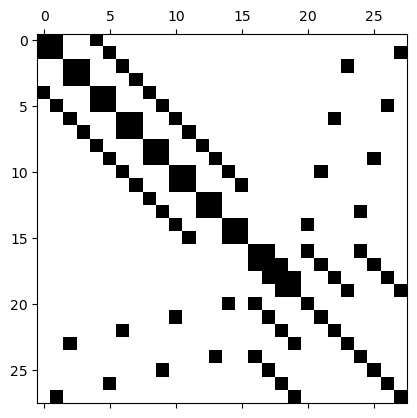

In [24]:
from matplotlib import pyplot as plt

plt.spy(jacobian.toarray())

# What have we explored
We have looked at the AD framework and how it is utilized by the PorePy models.

Key messages:
- The AD framework is capable of computing the Jacobian of an equation automatically. 
- In PorePy model, the AD objects are prepared in the `prepare_simulation` method.
- The variables are defined in the `create_variables` method.
- The equations are assembled from the variables in the `set_equations` method.
- The process of assembling an equation is modular. You can access separate terms of an equation by calling the model methods. 
- The equations can be evaluated many times with the new values of the variables, and the Jacobian will be computed automatically.


# Appendix: AD functions

This is the recipe for how to define an AD function. We will use our pressure variable from above and define the `sin` function.

In [25]:
p

Mixed-dimensional variable with name pressure, id 28
Composed of 2 variables
Total size: 20

In [26]:
sin = pp.ad.Function(func=pp.ad.functions.sin, name="sin_function")
sin

AD Operator function 'sin_function'

`func` can be anything that takes `AdArray` and returns `AdArray`.

In [27]:
y = sin(p)
y

Operator with no name formed by Operations.evaluate with 2 children.

In [28]:
result = sin(p).evaluate(model.equation_system)
result

Ad array of size 20
Jacobian is of size (20, 28) and has 20 elements